In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers
import pickle
import tensorflow as tf

In [ ]:
stocksDf =  pd.read_csv('/content/sample_data/stocksList.csv')
stocksDf.index = stocksDf.pop('Sıra No')
stocksCode = stocksDf['Pay Kodu'].to_numpy()


historicalDataBist100 = []
for i in range(0,len(stocksCode)):
  dfTemp = yf.download(stocksCode[i]+'.IS')
  historicalDataBist100.append(dfTemp)


length = len(historicalDataBist100)
i = 0
while i < length:
  if len(historicalDataBist100[i]) <= 5:
    del historicalDataBist100[i]
    stocksCode = np.delete(stocksCode, i)
    i = i - 3
    length = length - 1
  historicalDataBist100[i] = historicalDataBist100[i][['Open', 'High', 'Low', 'Volume', 'Close', 'Adj Close']]
  i = i + 1

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IEHYO.IS']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [ ]:
historicalDataIndex = yf.download('XU100.IS')

def convert_datetime(d):
  split = d.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)

def set_df(dataframe, historicalDataIndex, strFirstDate, strLastDate, n = 4):
  firstDate = convert_datetime(strFirstDate)
  lastDate = convert_datetime(strLastDate)

  targetDate = firstDate

  dates, laterDates = [], []
  X1, X2, X3, X4, X5, X6, iX1, iX2, iX3, iX4, iX5, iX6, Y = [], [], [], [], [], [], [], [], [], [], [], [], []

  while True:
    df_subset = dataframe.loc[:targetDate].tail(n+1)

    while (len(df_subset) != n+1 or targetDate.weekday() == 5 or targetDate.weekday() == 6):
      if targetDate.weekday() == 4:
        targetDate = targetDate + datetime.timedelta(days = 3)
        df_subset = dataframe.loc[:targetDate].tail(n+1)

      else:
        targetDate = targetDate + datetime.timedelta(days = 1)
        df_subset = dataframe.loc[:targetDate].tail(n+1)

      if (targetDate - lastDate).days >= 0:
        break

    dfIndex = historicalDataIndex.loc[:targetDate].tail(n+1)

    val1 = df_subset['Close'].to_numpy()
    val2 = df_subset['Adj Close'].to_numpy()
    val3 = df_subset['Open'].to_numpy()
    val4 = df_subset['High'].to_numpy()
    val5 = df_subset['Low'].to_numpy()
    val6 = df_subset['Volume'].to_numpy()

    ival1 = dfIndex['Close'].to_numpy()
    ival2 = dfIndex['Adj Close'].to_numpy()
    ival3 = dfIndex['Open'].to_numpy()
    ival4 = dfIndex['High'].to_numpy()
    ival5 = dfIndex['Low'].to_numpy()
    ival6 = dfIndex['Volume'].to_numpy()

    y= val1[-1]
    x1, x2, x3, x4, x5, x6 = val1[:-1], val2[:-1], val3[:-1], val4[:-1], val5[:-1], val6[:-1]
    ix1, ix2, ix3, ix4, ix5, ix6 = ival1[:-1], ival2[:-1], ival3[:-1], ival4[:-1], ival5[:-1], ival6[:-1]

    dates.append(targetDate)
    laterDates.append(targetDate + datetime.timedelta(days = 7))

    X1.append(x1)
    X2.append(x2)
    X3.append(x3)
    X4.append(x4)
    X5.append(x5)
    X6.append(x6)

    iX1.append(ix1)
    iX2.append(ix2)
    iX3.append(ix3)
    iX4.append(ix4)
    iX5.append(ix5)
    iX6.append(ix6)

    Y.append(y)

    if targetDate.weekday() == 4:
      targetDate = targetDate + datetime.timedelta(days = 3)
    else:
      targetDate = targetDate + datetime.timedelta(days = 1)

    if (targetDate - lastDate).days >= 0:
      break

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X1 = np.array(X1)
  X2 = np.array(X2)
  X3 = np.array(X3)
  X4 = np.array(X4)
  X5 = np.array(X5)
  X6 = np.array(X6)
  iX1 = np.array(iX1)
  iX2 = np.array(iX2)
  iX3 = np.array(iX3)
  iX4 = np.array(iX4)
  iX5 = np.array(iX5)
  iX6 = np.array(iX6)

  for i in range(0, n):
    ret_df[f'Close-{n-i}'] = X1[:,i]
    ret_df[f'Adj Close-{n-i}'] = X2[:,i]
    ret_df[f'Open-{n-i}'] = X3[:,i]
    ret_df[f'High-{n-i}'] = X4[:,i]
    ret_df[f'Low-{n-i}'] = X5[:,i]
    ret_df[f'Volume-{n-i}'] = X6[:,i]

    ret_df[f'I-Close-{n-i}'] = iX1[:,i]
    ret_df[f'I-Adj Close-{n-i}'] = iX2[:,i]
    ret_df[f'I-Open-{n-i}'] = iX3[:,i]
    ret_df[f'I-High-{n-i}'] = iX4[:,i]
    ret_df[f'I-Low-{n-i}'] = iX5[:,i]
    ret_df[f'I-Volume-{n-i}'] = iX6[:,i]

  ret_df['Daily Target'] = Y

  return ret_df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
setted_dfs = []
for i in range(0, len(historicalDataBist100)):
  setted_dfs.append(set_df(
  historicalDataBist100[i],
  historicalDataIndex,
  (historicalDataBist100[i].index[0] + datetime.timedelta(days = 4)).strftime("%Y-%m-%d"),
  (historicalDataBist100[i].index[-1]).strftime("%Y-%m-%d"),
  n = 4
  ))

In [ ]:
def windowed_df_to_date(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  return dates

def windowed_df_to_X(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  return X.astype(np.float32)

def windowed_df_to_Y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  Y = df_as_np[:, -1]
  return Y.astype(np.float32)

In [ ]:
dates, X, Y = [], [], []

for i in range(0, len(setted_dfs)):
  dates.append(windowed_df_to_date(setted_dfs[i]))
  X.append(windowed_df_to_X(setted_dfs[i]))
  Y.append(windowed_df_to_Y(setted_dfs[i]))

In [ ]:
model = tf.keras.models.load_model('/content/sample_data/model7.h5')

In [ ]:
for i in range(0, len(stocksCode)):
  print(str(i) + " : " + stocksCode[i])

0 : AFYON
1 : AKCNS
2 : AKSA
3 : AKSEN
4 :  ALBRK
5 : ALCTL
6 : ALKA
7 : ALKIM
8 : ASUZU
9 : ARDYZ
10 : ASGYO
11 : ASELS
12 : ATAKP
13 : BIMAS
14 : BRLSM
15 : BUCIM
16 : CLEBI
17 : CEMAS
18 : CEMTS
19 : CWENE
20 : DARDL
21 : DOAS
22 : EGPRO
23 : ENJSA
24 : ERCB
25 : EREGL
26 : TEZOL
27 : FORMT
28 : FZLGY
29 : GEREL
30 : GESAN
31 : GOLTS
32 : GOODY
33 : GUBRF
34 : IHLGM
35 : ISDMR
36 : JANTS
37 : KLKIM
38 : KLSER
39 : KRDMD
40 : KARSN
41 : KTLEV
42 : KATMR
43 : KAYSE
44 : KRVGD
45 : KZBGY
46 : KONTR
47 : KONYA
48 : KONKA
49 : KRSTL
50 : LOGO
51 : MAVI
52 : MNDRS
53 : MIATK
54 : MPARK
55 : NUHCM
56 : ODAS
57 : ORGE
58 : OYAKC
59 : PNLSN
60 : PARSN
61 : PASEU
62 : PSGYO
63 : PGSUS
64 : PEKGY
65 : PENTA
66 : POLHO
67 : RALYH
68 : SASA
69 : SELEC
70 : SNGYO
71 : SMRTG
72 : TKFEN
73 : TUKAS
74 : TMSN
75 : TUPRS
76 : THYAO
77 : PRKAB
78 : ULUUN
79 : VAKKO
80 : VESTL
81 : VESBE
82 : YATAS
83 : YYLGD
84 : YUNSA


In [ ]:
i = 19

dates_test = windowed_df_to_date(setted_dfs[i])
X_test = windowed_df_to_X(setted_dfs[i])
Y_test = windowed_df_to_Y(setted_dfs[i])

q_80 = int(len(dates_test) * .0)

dates_test = dates_test[q_80:]
X_test = X_test[q_80:]
Y_test = Y_test[q_80:]

6/6 [==============================] - 0s 17ms/step


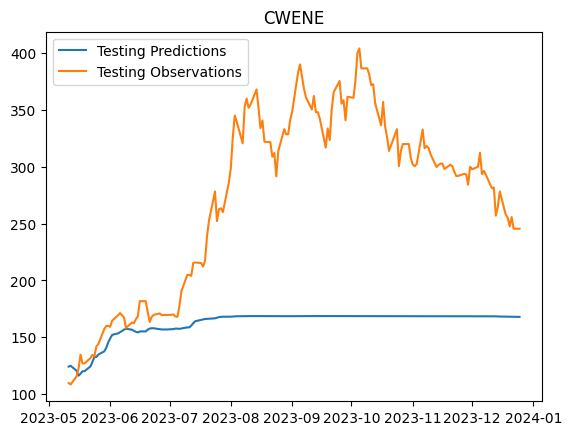

In [ ]:
test_pred = model.predict(X_test).flatten()

plt.title(stocksCode[i])
plt.plot(dates_test, test_pred)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

39/39 [==============================] - 1s 9ms/step


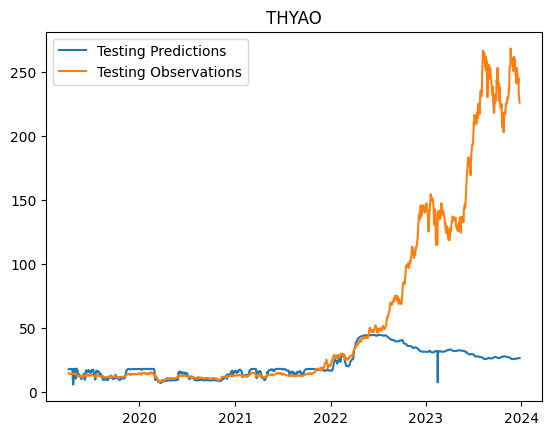

In [ ]:
test_pred = model1.predict(X_test).flatten()

plt.title(stocksCode[i])
plt.plot(dates_test, test_pred)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
test_pred[-1]

167.9456

In [ ]:
Y_test[-1]

245.5

193/193 [==============================] - 2s 10ms/step


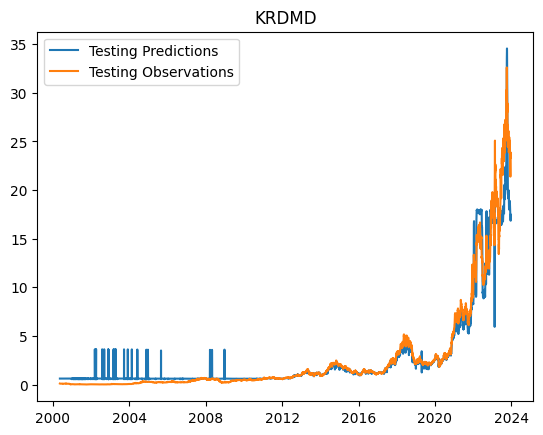

In [ ]:
test_pred = model.predict(X_test).flatten()

plt.title(stocksCode[i])
plt.plot(dates_test, test_pred)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])